In [108]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf

In [109]:
random.seed(101)
np.random.seed(101)
tf.random.set_seed(101)

In [110]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

In [111]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [112]:
df.columns = ['Sales']

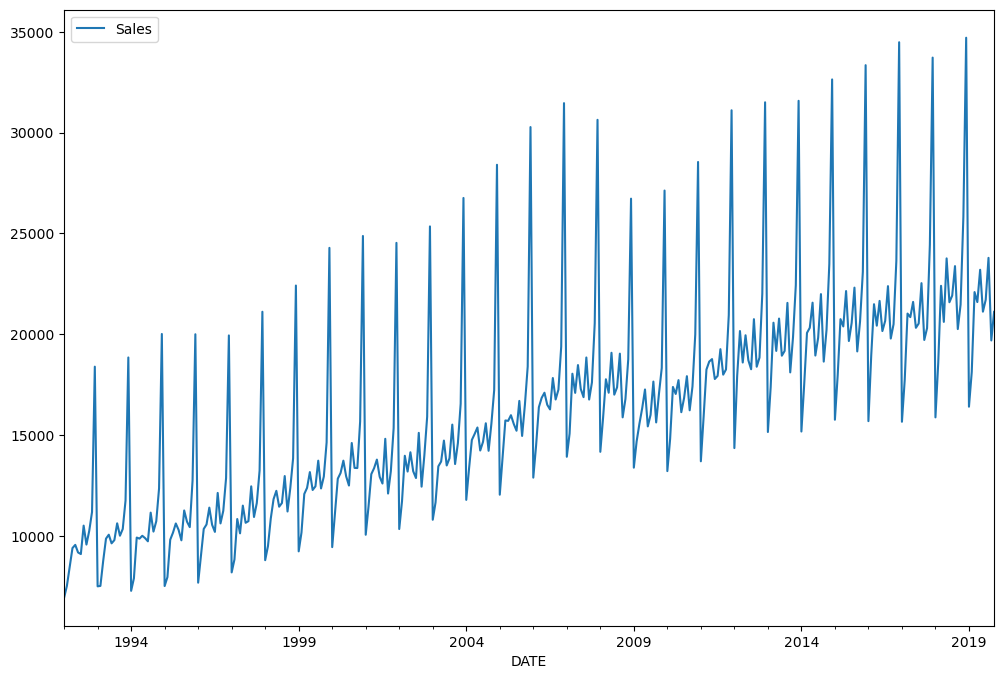

In [113]:
df.plot(figsize=(12,8));

## Répartition Entraînement / Test

In [114]:
len(df)

334

In [115]:
len(df)- 18

316

In [116]:
test_size = 18

In [117]:
test_ind = len(df)- test_size

In [118]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [119]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [120]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## Mise à l'échelle des données


In [121]:
from sklearn.preprocessing import MinMaxScaler

In [122]:
scaler = MinMaxScaler()

In [123]:
# Si warning, ignorez le, cest juste une conversion en float
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train)

MinMaxScaler()

In [124]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Générateur de séries temporelles


In [125]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [126]:
# Redéfinissons pour obtenir 12 mois en arrière et prédisons le mois suivant
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [127]:
# À quoi ressemble le premier batch ?
X,y = generator[0]

In [128]:
print(f"Compte tenu du tableau suivant : \n {X.flatten()}")
print(f'Cela prédit ce y : \n {y}')

Compte tenu du tableau suivant : 
 [0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Cela prédit ce y : 
 [[0.02047633]]


## Création du Modèle

In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [130]:
# Nous n'utilisons qu'une seule feature dans notre série temporelle
n_features = 1 

In [131]:
# définir le modèle
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [132]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping et création d'un Générateur de Validation


In [133]:
from tensorflow.keras.callbacks import EarlyStopping

In [134]:
    early_stop = EarlyStopping(monitor='val_loss',patience=4)

In [135]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [136]:
# ajustement du modèle
model.fit(generator,epochs=30,
                    validation_data=validation_generator,
                    callbacks=[early_stop]
                   )

Epoch 1/30
304/304 [==============================] - 6s 10ms/step - loss: 0.0259 - val_loss: 0.0066
Epoch 2/30
304/304 [==============================] - 3s 10ms/step - loss: 0.0180 - val_loss: 0.0056
Epoch 3/30
304/304 [==============================] - 3s 10ms/step - loss: 0.0136 - val_loss: 0.0045
Epoch 4/30
304/304 [==============================] - 3s 10ms/step - loss: 0.0087 - val_loss: 0.0133
Epoch 5/30
304/304 [==============================] - 3s 9ms/step - loss: 0.0036 - val_loss: 9.1325e-04
Epoch 6/30
304/304 [==============================] - 2s 6ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 7/30
304/304 [==============================] - 3s 10ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/30
304/304 [==============================] - 3s 10ms/step - loss: 0.0016 - val_loss: 3.0175e-04
Epoch 9/30
304/304 [==============================] - 3s 10ms/step - loss: 0.0016 - val_loss: 0.0039
Epoch 10/30
304/304 [==============================] - 3s 10ms/step - loss: 0.0014 - 

In [137]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot: >

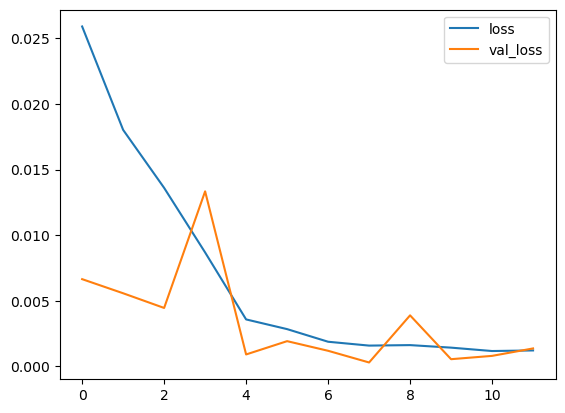

In [138]:
losses.plot()

## Évaluation sur les données de test

In [139]:
first_eval_batch = scaled_train[-length:]

In [140]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [141]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 455ms/step


array([[0.554832]], dtype=float32)

In [142]:
scaled_test[0]

array([0.61087714])

In [143]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 68ms/step


## Transformations inverses et Comparaison

In [144]:
true_predictions = scaler.inverse_transform(test_predictions)

In [145]:
# Ignorez le warning
test['Predictions'] = true_predictions

C:\Users\HP\AppData\Local\Temp\ipykernel_7164\3589043930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [146]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22220.292103
2018-06-01,21589,21165.111252
2018-07-01,21919,21407.249726
2018-08-01,23381,23040.091924
2018-09-01,20260,20682.571277
2018-10-01,21473,21273.524236
2018-11-01,25831,24766.686275
2018-12-01,34706,33186.790325
2019-01-01,16410,16756.251471


In [147]:
from sklearn.metrics import mean_squared_error

In [148]:
mse = mean_squared_error(test['Sales'], test['Predictions'])
rmse = np.sqrt(mse)
print(rmse)

880.3467331886069


<AxesSubplot: xlabel='DATE'>

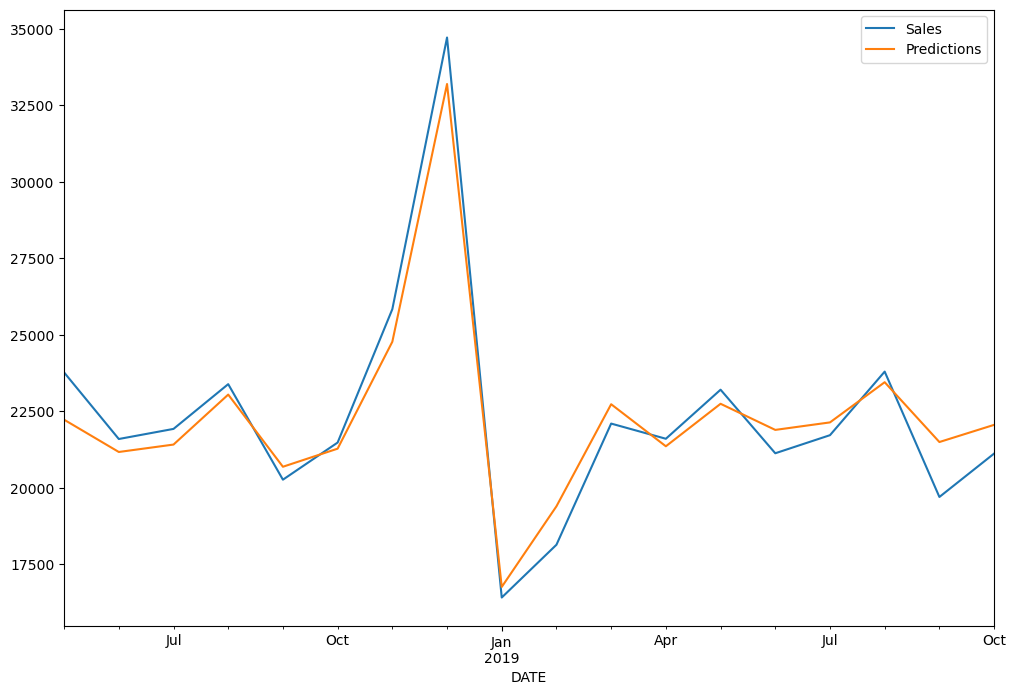

In [149]:
test.plot(figsize=(12,8))

## Ré-Entraînement et Prévision


In [150]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [151]:
length = 12 # Longueur des séquences de sortie (en nombre de pas temporel)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [152]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# ajustement du modèle
model.fit(generator,epochs=12)

Epoch 1/12
322/322 [==============================] - 5s 6ms/step - loss: 0.0254
Epoch 2/12
322/322 [==============================] - 3s 10ms/step - loss: 0.0190
Epoch 3/12
322/322 [==============================] - 3s 10ms/step - loss: 0.0147
Epoch 4/12
322/322 [==============================] - 3s 10ms/step - loss: 0.0074
Epoch 5/12
322/322 [==============================] - 3s 10ms/step - loss: 0.0067
Epoch 6/12
322/322 [==============================] - 2s 6ms/step - loss: 0.0020
Epoch 7/12
322/322 [==============================] - 3s 9ms/step - loss: 0.0026
Epoch 8/12
322/322 [==============================] - 3s 10ms/step - loss: 0.0015
Epoch 9/12
322/322 [==============================] - 3s 10ms/step - loss: 0.0015
Epoch 10/12
322/322 [==============================] - 3s 10ms/step - loss: 0.0011
Epoch 11/12
322/322 [==============================] - 3s 8ms/step - loss: 0.0013
Epoch 12/12
322/322 [==============================] - 2s 7ms/step - loss: 0.0014


In [153]:
forecast = []
# Remplacez les périodes par la durée de prévision que vous souhaitez
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    forecast.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 65ms/step


In [154]:
forecast = full_scaler.inverse_transform(forecast)

In [155]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [156]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [157]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [158]:
forecast_df

,Forecast
2019-11-01,26156.076900
2019-12-01,36242.086718
2020-01-01,16323.820666
2020-02-01,18344.261333
2020-03-01,21905.214459
2020-04-01,21531.217731
2020-05-01,23071.035048
2020-06-01,21129.769485
2020-07-01,21776.245619
2020-08-01,23805.183578


<AxesSubplot: >

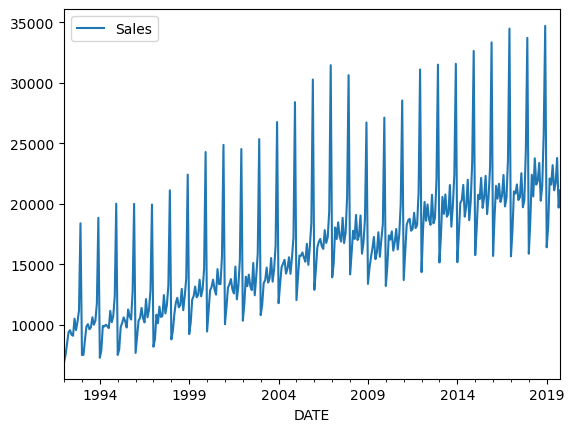

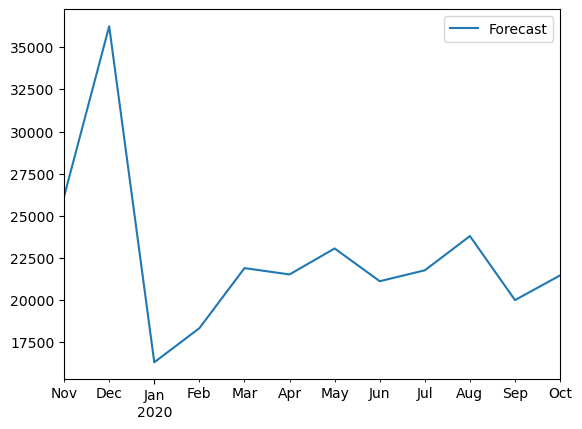

In [159]:
df.plot()
forecast_df.plot()

<AxesSubplot: xlabel='DATE'>

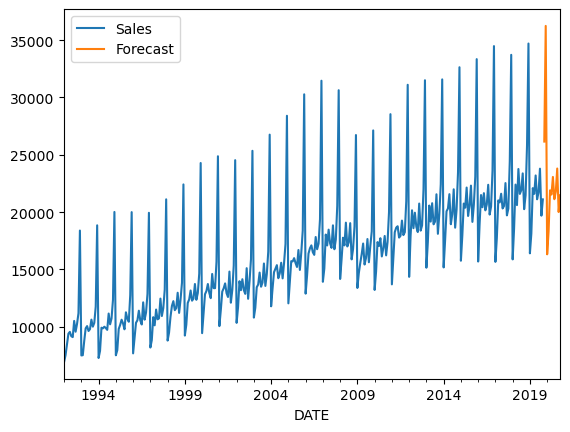

In [160]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

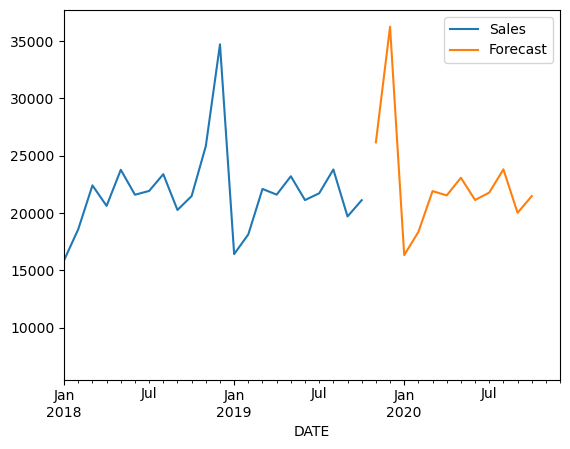

In [161]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')